# Strange Symbols Classification Task

This notebook tackles the **Strange Symbols Classification** test task.

## Dataset Analysis
The first step involved analyzing the provided dataset to gain a better understanding of the data. Here’s what was done:  
- Checked the **dimensionality** of the dataset.  
- Visualized the provided grayscale images to understand their structure.

### Key Findings
- The dataset contains **15,000 grayscale images**, each of size **28x28 pixels**.  
- Each image is assigned an **integer label** ranging from **0 to 14**, making this a **15-class classification problem**. 


Image count: 15000
Image Shape: torch.Size([28, 28])
Lable type: <class 'int'>
Distinct labels:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

Image Examples:



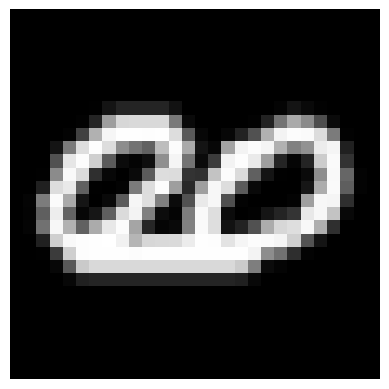

Label: 8


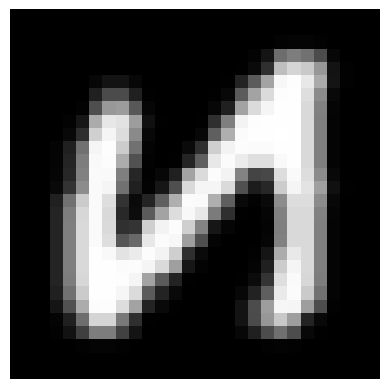

Label: 0


In [46]:
import torch
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

training_data = torch.load('strange_symbols/training_data.pt')
training_labels = torch.load('strange_symbols/training_labels.pt')

print(f'Image count: {len(training_data)}')
print(f'Image Shape: {training_data[0].shape}')
print(f'Lable type: {type(training_labels[0])}')
print(f'Distinct labels:\n {set(training_labels)}\n')

print('Image Examples:\n')
for index in range(2):
    plt.imshow(training_data[index].numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
    print(f'Label: {training_labels[index]}')
    



## The `CustomTensorDataset` Class

The `CustomTensorDataset` class is designed to format the input data, making it compatible with the **`Conv2d` layers** in PyTorch.  

### Key Features
- **Data Normalization**: Converts 8-bit integer values into **float values** ranging between **0 and 1**.  
- **Dimensionality Adjustment**: Adds an additional dimension to the data, as required by the **`Conv2d` layers**.

In [47]:
from torch.utils.data import Dataset, DataLoader, Subset

# Custom Dataset class to handle the .pt files
class CustomTensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.float() / 255.0
        self.data = self.data.unsqueeze(1)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return x, y
        else:
            return x
        

# Instantiate datasets and dataloaders
train_dataset = CustomTensorDataset(training_data, training_labels)

## The `SimpleCNN` Class

The `SimpleCNN` class implements the neural network for this task.  

### Why a CNN?
Since we are working with image data, a **Convolutional Neural Network (CNN)** is a suitable choice. CNNs are effective in:  
- Preserving **spatial information** in images.  
- Extracting **relevant features** essential for classification.

### Network Design
- Due to the relatively small size of the dataset, the network includes **two convolutional layers**.  
- During the forward pass:
  - **ReLU activation function** is applied after each convolution.  
  - **Max pooling** is used to reduce the size of the images and retain key features.  


In [48]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 15)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Model Training: 5-Fold Cross-Validation

To train the model, **5-fold cross-validation** is employed using the `StratifiedKFold` class from the **scikit-learn** library. This approach is particularly beneficial for classification tasks as it helps avoid biases by maintaining the proportion of classes in each fold.

### Training Process
- The model is trained **individually** for each split of the validation and training sets.  
- **Batch size**: 32  
- **Optimizer**: Adam (built into PyTorch).  
- **Training progress**: Visualized using the `tqdm` library.

### Epochs and Early Stopping
- The model is trained for **5 epochs** (a hyperparameter that can be adjusted as needed).  
- Optionally, an **early stopping** mechanism can be implemented to monitor losses and terminate training if losses rise beyond a certain threshold, helping to prevent overfitting.

### Code Organization
The training process is divided into three separate functions to:
- Improve code readability.  
- Avoid the complexity of nested loops.  

In [49]:
from tqdm import tqdm

def calc_val_loss(model, val_loader, criterion):
    '''Calculate the validation loss for the specified model validation data and loss function'''
    val_loss = 0
    # Loop thru the validation data while not computing the gradient
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()

    val_loss /= len(val_loader)
    return val_loss

def calc_val_accuracy(model, val_loader, criterion):
    '''Calculate the validation loss for the specified model validation data and loss function'''
    correct = 0
    total = 0
    val_loss = 0
    # Loop thru the validation data while not computing the gradient
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            _,predicted = torch.max(output,1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            val_loss += criterion(output, target).item()

    accuracy = 100 * correct / total
    return accuracy


def forward_backward_propagation(model, train_loader, optimizer, criterion):
    '''Perfom forward and backward propagation'''
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    '''Perfom training loop over the specified parameters'''
    for epoch in tqdm(range(epochs)):  # Adjust the number of epochs as needed
        
        model.train()
        
        forward_backward_propagation(model, train_loader, optimizer, criterion)
        
        model.eval()
        
        # Calculate the loss with the validation set
        val_accuracy = calc_val_accuracy(model, val_loader, criterion)
        print(f'Validation accuracy in  epoch {epoch+1}: {val_accuracy:.4f} %')
        
    return val_accuracy

## Final Training Implementation

Below is the **final training implementation**, which integrates the previously defined functions. These functions streamline the process and ensure the training pipeline is clean and organized.

In [ ]:

from sklearn.model_selection import StratifiedKFold
import torch.optim as optim


folds = 5
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=11)
val_accuracies = []
#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss()
epochs = 5

#Loop thrue the k folds of f fold cross validation 
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset,training_labels)):
    print(f'\nFold {fold + 1}:')

    train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=32, shuffle=False)

    # Initialize the model and optimizer
    model = SimpleCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop runs for every epoch
    val_accuracy = train_model(model, train_loader, val_loader, epochs, criterion, optimizer)
    val_accuracies.append(val_accuracy)    
    print(f"Fold {fold+1} completed with Validation accuracy: {val_accuracy:.4f} %\n")


Fold 1:


 20%|██        | 1/5 [00:03<00:12,  3.23s/it]

Validation accuracy in  epoch 1: 85.6667 %


 40%|████      | 2/5 [00:06<00:09,  3.20s/it]

Validation accuracy in  epoch 2: 89.7667 %


 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

Validation accuracy in  epoch 3: 89.5000 %


 80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

Validation accuracy in  epoch 4: 89.7333 %


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


Validation accuracy in  epoch 5: 91.5000 %
Fold 1 completed with Validation accuracy: 91.5000 %


Fold 2:


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Validation accuracy in  epoch 1: 85.9667 %


 40%|████      | 2/5 [00:06<00:09,  3.18s/it]

Validation accuracy in  epoch 2: 89.0333 %


 60%|██████    | 3/5 [00:09<00:06,  3.30s/it]

Validation accuracy in  epoch 3: 89.9000 %


 80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

Validation accuracy in  epoch 4: 90.5333 %


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Validation accuracy in  epoch 5: 90.9667 %
Fold 2 completed with Validation accuracy: 90.9667 %


Fold 3:


 20%|██        | 1/5 [00:03<00:12,  3.13s/it]

Validation accuracy in  epoch 1: 85.1333 %


 40%|████      | 2/5 [00:06<00:09,  3.15s/it]

Validation accuracy in  epoch 2: 88.8667 %


 60%|██████    | 3/5 [00:09<00:06,  3.32s/it]

Validation accuracy in  epoch 3: 90.3333 %


 80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

Validation accuracy in  epoch 4: 89.4000 %


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


Validation accuracy in  epoch 5: 91.1667 %
Fold 3 completed with Validation accuracy: 91.1667 %


Fold 4:


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Validation accuracy in  epoch 1: 86.0667 %


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

Validation accuracy in  epoch 2: 88.5333 %


 60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

Validation accuracy in  epoch 3: 89.6667 %


 80%|████████  | 4/5 [00:13<00:03,  3.31s/it]

Validation accuracy in  epoch 4: 90.4000 %


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


Validation accuracy in  epoch 5: 91.3000 %
Fold 4 completed with Validation accuracy: 91.3000 %


Fold 5:


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Validation accuracy in  epoch 1: 86.1000 %


 40%|████      | 2/5 [00:06<00:09,  3.18s/it]

Validation accuracy in  epoch 2: 89.5333 %


 60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

Validation accuracy in  epoch 3: 90.4667 %


 80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

Validation accuracy in  epoch 4: 91.2667 %


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

Validation accuracy in  epoch 5: 91.8000 %
Fold 5 completed with Validation accuracy: 91.8000 %



In [52]:
import numpy as np

average_val_loss = np.mean(val_accuracies)
print(f"Average Validation accuracy across {5} folds: {average_val_loss:.4f} %")

Average Validation accuracy across 5 folds: 91.3467 %
